In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import os
from IPython.core.interactiveshell import InteractiveShell
pd.set_option("display.precision", 3)
InteractiveShell.ast_node_interactivity = "all"

In [13]:
# Extra imports
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix,\
        accuracy_score, classification_report, f1_score, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,GradientBoostingClassifier,StackingClassifier,ExtraTreesClassifier
#from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import plot_confusion_matrix

from sklearn import svm
from sklearn.preprocessing import MinMaxScaler

from sklearn.compose import ColumnTransformer

from time import time
from datetime import timedelta

from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

import seaborn as sns
from matplotlib import pyplot as plt

sns.set()

import warnings
warnings.filterwarnings('ignore')

In [ ]:
local_dir = os.getcwd()
#data_path = COSTUM_DATA_LOCATION
#model_path = COSTUM_MODEL_LOCATION
data_path = os.path.join(os.path.dirname(os.path.dirname(local_dir)),'data')
model_path = os.path.join(os.path.dirname(local_dir),'models')

In [5]:
# Prepare data function used in other scripts 

def prepare_data(dataframe, variables, num_scaling = True):
    x = dataframe.loc[:, dataframe.columns != 'SUSPECT_RACE_DESCRIPTION']
    y = dataframe.loc[:, 'SUSPECT_RACE_DESCRIPTION']
    X_train, X_test, y_train, y_test =\
        train_test_split(x,y, test_size=0.2, random_state=14, stratify=y)
    X_train = X_train.loc[:,variables]
    X_test = X_test.loc[:,variables]
    X_train = pd.get_dummies(X_train)
    X_test = pd.get_dummies(X_test)
    X_train, X_test = X_train.align(X_test, join='inner', axis=1, fill_value=0)
    numericals = []
    for idx, types in enumerate(X_train.dtypes):
        if types == 'int64':
            numericals.append(X_train.columns[idx])
    if num_scaling:
        ct = ColumnTransformer([
                ('somename', MinMaxScaler(), numericals)
            ], remainder='passthrough')

        ct.fit_transform(X_train)
        ct.fit_transform(X_test)
    return X_train, X_test, y_train, y_test


df = pd.read_csv(os.path.join(data_path,'train_preprocessed_final_noMCA.csv'), index_col=[0])

vars_to_keep =  list(df.columns)
vars_to_keep.remove('SUSPECT_RACE_DESCRIPTION')

df['KMEANS_DEMEANOR'] = df.KMEANS_DEMEANOR.astype('object')


X_train, X_test, y_train, y_test = prepare_data(df, vars_to_keep, num_scaling=True)

# 1. OVO / OVR APPROACH

In [6]:
# Difference between 

linear_ovo = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo', class_weight="balanced", random_state = 14).fit(X_train, y_train)
linear_ovr = svm.LinearSVC(C=1, class_weight="balanced", random_state = 14).fit(X_train, y_train)

In [7]:
y_pred_linear_ovo = linear_ovo.predict(X_test)
y_pred_linear_ovr  = linear_ovr.predict(X_test)

print(f1_score(y_test, y_pred_linear_ovo, average="macro"))
print(f1_score(y_test, y_pred_linear_ovr, average="macro"))



0.43074691310070423
0.31053865601761554


# 2. Linear, Polynomial, RBF, Sigmoid

In [8]:
linear = svm.SVC(kernel='linear', cache_size = 1000, C=1, decision_function_shape='ovo', class_weight="balanced", random_state = 14).fit(X_train, y_train)
rbf = svm.SVC(kernel='rbf', cache_size = 1000,  gamma="scale", C=1, decision_function_shape='ovo', class_weight="balanced", random_state = 14).fit(X_train, y_train)
poly = svm.SVC(kernel='poly', cache_size = 1000, degree=3, C=1, decision_function_shape='ovo', class_weight="balanced", random_state = 14).fit(X_train, y_train)
sig = svm.SVC(kernel='sigmoid', cache_size = 1000, C=1, decision_function_shape='ovo', class_weight="balanced", random_state = 14).fit(X_train, y_train)

In [9]:
y_pred_linear = linear.predict(X_test)
y_pred_rbf = rbf.predict(X_test)
y_pred_poly = poly.predict(X_test)
y_pred_sigmoid = sig.predict(X_test)


print(f1_score(y_test, y_pred_linear, average="macro"))
print(f1_score(y_test, y_pred_rbf, average="macro"))
print(f1_score(y_test, y_pred_poly, average="macro"))
print(f1_score(y_test, y_pred_sigmoid, average="macro"))

0.43074691310070423
0.3577383080699527
0.25655868101244556
0.27191815121341123


In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=rf_model_tuned.classes_)


# 3. Linear CV

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

C_range = np.logspace(-3, 1, 5)
param_grid = dict(C=C_range)
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats=3, random_state=14, shuffle=True)
grid = GridSearchCV(linear, param_grid=param_grid, cv=cv, verbose=3)
grid.fit(X_train, y_train)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

C_range = np.logspace(-3, 1, 5)
param_grid = dict(C=C_range)
scoring_dict = {
    'f1_mac': 'f1_macro',
    'acc': 'balanced_accuracy',
}

cv = RepeatedStratifiedKFold(n_splits = 3, n_repeats=1, random_state=14)
grid = GridSearchCV(linear, param_grid=param_grid, scoring = scoring_dict, refit="f1_mac", cv=cv, verbose=3)
modelcv_lin = grid.fit(X_train, y_train)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END .C=0.001; acc: (test=0.447) f1_mac: (test=0.392) total time=  10.2s
[CV 2/3] END .C=0.001; acc: (test=0.437) f1_mac: (test=0.363) total time=   7.8s
[CV 3/3] END .C=0.001; acc: (test=0.451) f1_mac: (test=0.411) total time=   7.6s
[CV 1/3] END ..C=0.01; acc: (test=0.525) f1_mac: (test=0.427) total time=   8.0s
[CV 2/3] END ..C=0.01; acc: (test=0.508) f1_mac: (test=0.409) total time=  10.5s
[CV 3/3] END ..C=0.01; acc: (test=0.469) f1_mac: (test=0.418) total time=   9.9s
[CV 1/3] END ...C=0.1; acc: (test=0.540) f1_mac: (test=0.435) total time=  16.9s
[CV 2/3] END ...C=0.1; acc: (test=0.499) f1_mac: (test=0.409) total time=  14.3s
[CV 3/3] END ...C=0.1; acc: (test=0.482) f1_mac: (test=0.421) total time=  14.6s
[CV 1/3] END ...C=1.0; acc: (test=0.534) f1_mac: (test=0.428) total time= 1.7min
[CV 2/3] END ...C=1.0; acc: (test=0.502) f1_mac: (test=0.412) total time= 1.5min
[CV 3/3] END ...C=1.0; acc: (test=0.471) f1_mac: 

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=3, random_state=14),
             estimator=SVC(C=1, cache_size=1000, class_weight='balanced',
                           decision_function_shape='ovo', kernel='linear',
                           random_state=14),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])},
             refit='f1_mac',
             scoring={'acc': 'balanced_accuracy', 'f1_mac': 'f1_macro'},
             verbose=3)

The best parameters are {'C': 0.1} with a score of 0.42


# 4. Polynomial CV

In [31]:
# Polynomial kernel
# Parameters first tried: C=10-3, 10-2, 10-1, 1, gamma = 10-2,10-1,1,10, degree = 1, coef0=1

C_range = np.logspace(-3, 0, 4)
gamma_range = np.logspace(-2,1,4)
degree_range = [1]
coef0_range = [1]
param_grid = dict(C=C_range, gamma = gamma_range, degree=degree_range, coef0 = coef0_range)
scoring_dict = {
    'f1_mac': 'f1_macro',
    'acc': 'balanced_accuracy',
}

cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats=1, random_state=14)
grid = GridSearchCV(poly, param_grid=param_grid, scoring = scoring_dict, refit="f1_mac", cv=cv, verbose=3)
modelcv_poly = grid.fit(X_train, y_train)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END C=0.001, coef0=1, degree=1, gamma=0.01; acc: (test=0.374) f1_mac: (test=0.295) total time=   3.7s
[CV 2/5] END C=0.001, coef0=1, degree=1, gamma=0.01; acc: (test=0.385) f1_mac: (test=0.273) total time=   3.7s
[CV 3/5] END C=0.001, coef0=1, degree=1, gamma=0.01; acc: (test=0.312) f1_mac: (test=0.245) total time=   4.4s
[CV 4/5] END C=0.001, coef0=1, degree=1, gamma=0.01; acc: (test=0.380) f1_mac: (test=0.303) total time=   3.3s
[CV 5/5] END C=0.001, coef0=1, degree=1, gamma=0.01; acc: (test=0.385) f1_mac: (test=0.324) total time=   3.4s
[CV 1/5] END C=0.001, coef0=1, degree=1, gamma=0.1; acc: (test=0.367) f1_mac: (test=0.362) total time=   3.4s
[CV 2/5] END C=0.001, coef0=1, degree=1, gamma=0.1; acc: (test=0.345) f1_mac: (test=0.337) total time=   3.3s
[CV 3/5] END C=0.001, coef0=1, degree=1, gamma=0.1; acc: (test=0.367) f1_mac: (test=0.330) total time=   4.0s
[CV 4/5] END C=0.001, coef0=1, degree=1, gamma=0.1; ac

In [34]:
scoring_cols = [
    'mean_test_f1_mac', 'param_C', 'param_gamma', 'param_degree', 'param_coef0'] 
pd.DataFrame(modelcv_poly.cv_results_).sort_values(
    by='mean_test_f1_mac', ascending=False)[scoring_cols].head()

,mean_test_f1_mac,param_C,param_gamma,param_degree,param_coef0
11,0.430,0.1,10.0,1,1
7,0.426,0.01,10.0,1,1
13,0.425,1.0,0.1,1,1
10,0.425,0.1,1.0,1,1
14,0.424,1.0,1.0,1,1


In [35]:
y_pred = modelcv_poly.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=modelcv_poly.classes_)
cm

array([[641, 229, 118],
       [ 23,  32,   7],
       [155, 134, 175]], dtype=int64)

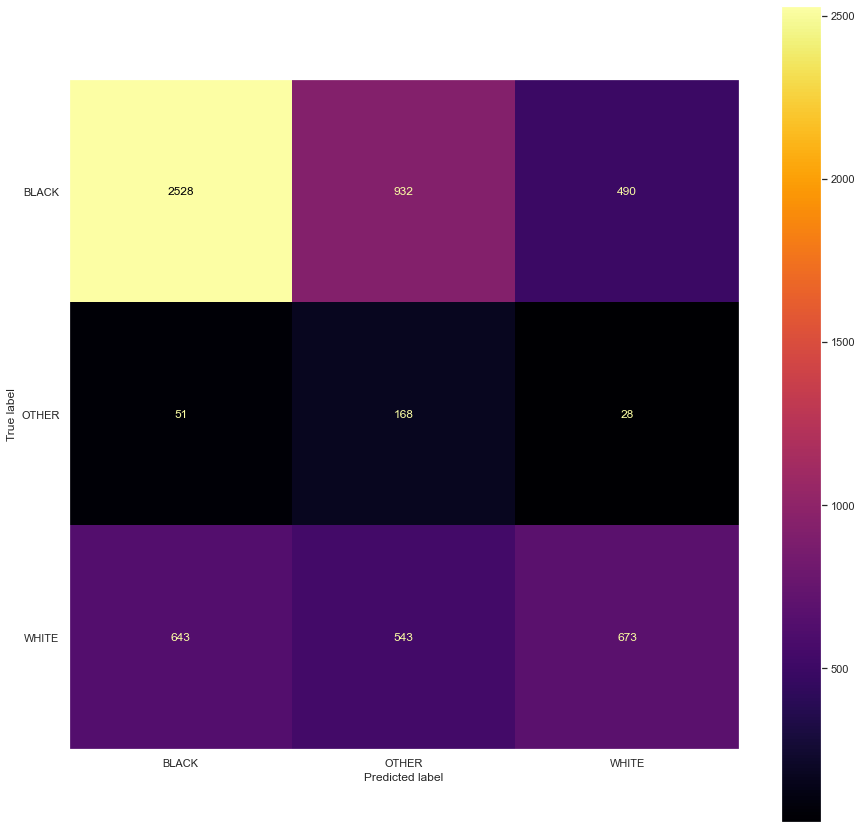

In [36]:
y_pred = modelcv_poly.predict(X_train)

cm = confusion_matrix(y_train, y_pred, labels= modelcv_poly.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= modelcv_poly.classes_)
fig, ax = plt.subplots(figsize=(15,15))
plt.grid(False)
disp.plot(ax=ax, cmap=plt.cm.inferno)

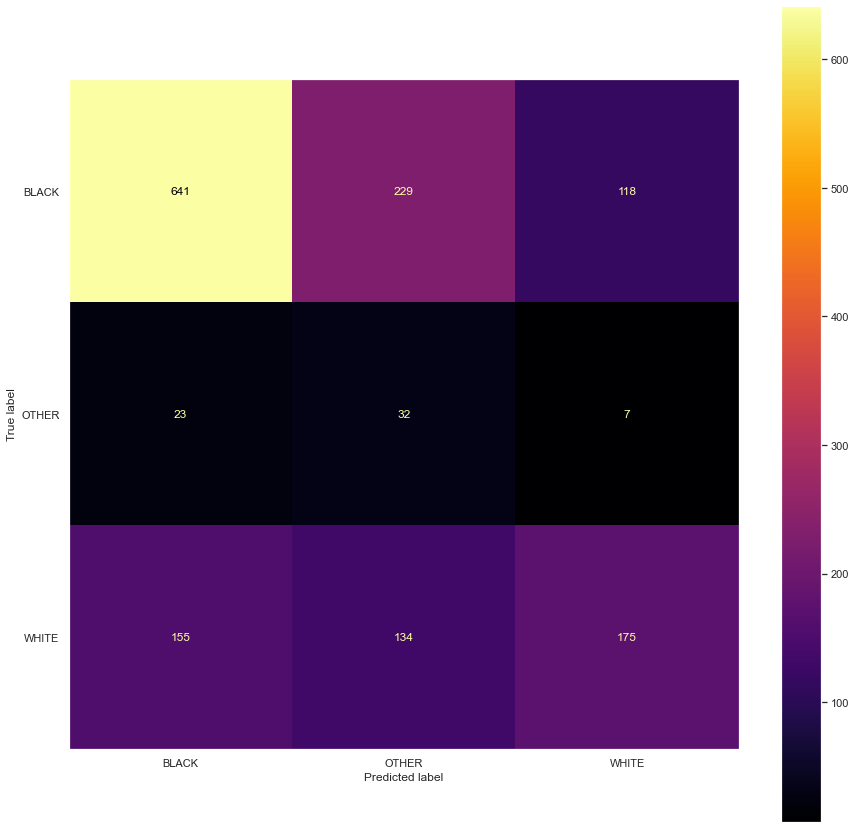

In [37]:
y_pred = modelcv_poly.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels= modelcv_poly.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= modelcv_poly.classes_)
fig, ax = plt.subplots(figsize=(15,15))
plt.grid(False)
disp.plot(ax=ax, cmap=plt.cm.inferno)

In [ ]:
scoring_cols = [
    'mean_test_f1_mac', 'param_C', 'param_gamma', 'param_degree', 'param_coef0'] 
pd.DataFrame(grid.cv_results_).sort_values(
    by='mean_test_f1_mac', ascending=False)[scoring_cols].head()

# 5. RBF CV

In [22]:
# RBF Kernel 
# Parameters first tried: C=10-3, 10-2, 10-1, 1, gamma = 10-2,10-1,1,10, coef0=1

C_range = np.logspace(-3, 0, 4)
gamma_range = np.logspace(-2,1,4)
coef0_range = [1, 0]
param_grid = dict(C=C_range, gamma = gamma_range, coef0 = coef0_range)
scoring_dict = {
    'f1_mac': 'f1_macro',
    'acc': 'balanced_accuracy',
}

cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats=2, random_state=14)
grid = GridSearchCV(rbf, param_grid=param_grid, scoring = scoring_dict, refit="f1_mac", cv=cv, verbose=3)
modelCV_rbf = grid.fit(X_train, y_train)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

Fitting 10 folds for each of 32 candidates, totalling 320 fits
[CV 1/10] END C=0.001, coef0=1, gamma=0.01; acc: (test=0.333) f1_mac: (test=0.263) total time=  14.5s
[CV 2/10] END C=0.001, coef0=1, gamma=0.01; acc: (test=0.333) f1_mac: (test=0.157) total time=  14.0s
[CV 3/10] END C=0.001, coef0=1, gamma=0.01; acc: (test=0.333) f1_mac: (test=0.157) total time=  14.5s
[CV 4/10] END C=0.001, coef0=1, gamma=0.01; acc: (test=0.333) f1_mac: (test=0.157) total time=  14.0s
[CV 5/10] END C=0.001, coef0=1, gamma=0.01; acc: (test=0.333) f1_mac: (test=0.156) total time=  14.2s
[CV 6/10] END C=0.001, coef0=1, gamma=0.01; acc: (test=0.333) f1_mac: (test=0.263) total time=  13.1s
[CV 7/10] END C=0.001, coef0=1, gamma=0.01; acc: (test=0.333) f1_mac: (test=0.157) total time=  12.5s
[CV 8/10] END C=0.001, coef0=1, gamma=0.01; acc: (test=0.333) f1_mac: (test=0.157) total time=  16.9s
[CV 9/10] END C=0.001, coef0=1, gamma=0.01; acc: (test=0.333) f1_mac: (test=0.157) total time=  12.3s
[CV 10/10] END C=0.

In [19]:
scoring_cols = [
    'mean_test_f1_mac', 'param_C', 'param_gamma', 'param_coef0'] 
pd.DataFrame(grid.cv_results_).sort_values(
    by='mean_test_f1_mac', ascending=False)[scoring_cols].head()

,mean_test_f1_mac,param_C,param_gamma,param_coef0
28,0.377,1.0,0.01,0.5
24,0.377,1.0,0.01,1
29,0.351,1.0,0.1,0.5
25,0.351,1.0,0.1,1
16,0.327,0.1,0.01,1


In [25]:
y_pred = modelCV_rbf.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=modelCV_rbf.classes_)
cm

array([[541, 131, 316],
       [ 23,  16,  23],
       [185,  59, 220]], dtype=int64)

# 6. Sigmoid CV

In [26]:
# Sigmoid Kernel 
# Parameters first tried: C=10-3, 10-2, 10-1, 1, gamma = 10-2,10-1,1,10, coef0=1

C_range = np.logspace(-3, 0, 4)
gamma_range = np.logspace(-2,1,4)
coef0_range = [1, 0]
param_grid = dict(C=C_range, gamma = gamma_range, coef0 = coef0_range)
scoring_dict = {
    'f1_mac': 'f1_macro',
    'acc': 'balanced_accuracy',
}

cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats=2, random_state=14)
grid = GridSearchCV(sig, param_grid=param_grid, scoring = scoring_dict, refit="f1_mac", cv=cv, verbose=3)
model_cv_sig = grid.fit(X_train, y_train)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

Fitting 10 folds for each of 32 candidates, totalling 320 fits
[CV 1/10] END C=0.001, coef0=1, gamma=0.01; acc: (test=0.333) f1_mac: (test=0.263) total time=   3.6s
[CV 2/10] END C=0.001, coef0=1, gamma=0.01; acc: (test=0.333) f1_mac: (test=0.157) total time=   2.3s
[CV 3/10] END C=0.001, coef0=1, gamma=0.01; acc: (test=0.333) f1_mac: (test=0.157) total time=   2.0s
[CV 4/10] END C=0.001, coef0=1, gamma=0.01; acc: (test=0.333) f1_mac: (test=0.157) total time=   2.1s
[CV 5/10] END C=0.001, coef0=1, gamma=0.01; acc: (test=0.333) f1_mac: (test=0.156) total time=   2.2s
[CV 6/10] END C=0.001, coef0=1, gamma=0.01; acc: (test=0.333) f1_mac: (test=0.263) total time=   2.1s
[CV 7/10] END C=0.001, coef0=1, gamma=0.01; acc: (test=0.333) f1_mac: (test=0.157) total time=   2.0s
[CV 8/10] END C=0.001, coef0=1, gamma=0.01; acc: (test=0.333) f1_mac: (test=0.157) total time=   2.4s
[CV 9/10] END C=0.001, coef0=1, gamma=0.01; acc: (test=0.333) f1_mac: (test=0.157) total time=   2.4s
[CV 10/10] END C=0.

In [27]:
scoring_cols = [
    'mean_test_f1_mac', 'param_C', 'param_gamma', 'param_coef0'] 
pd.DataFrame(grid.cv_results_).sort_values(
    by='mean_test_f1_mac', ascending=False)[scoring_cols].head()

,mean_test_f1_mac,param_C,param_gamma,param_coef0
0,0.178,0.001,0.01,1
1,0.178,0.001,0.1,1
30,0.178,1.0,1.0,0
29,0.178,1.0,0.1,0
28,0.178,1.0,0.01,0


In [39]:
y_pred = sig.predict(X_train)

cm = confusion_matrix(y_train, y_pred, labels=model_cv_sig.classes_)
cm


array([[3792,   24,  134],
       [ 237,    0,   10],
       [1772,    9,   78]], dtype=int64)

# 7. Extra

<AxesSubplot:>

Text(0.5, 0, 'Age')

Text(0, 0.5, 'Height')

Text(0.5, 1.0, 'SVM Decision Region Boundary')

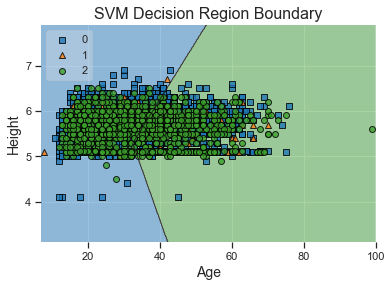

In [ ]:
# Some visualization !!!

from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt


plot_decision_regions(X=x, 
                      y=y,
                      clf=linear, 
                      legend=2)

# Update plot object with X/Y axis labels and Figure Title
plt.xlabel("Age", size=14)
plt.ylabel("Height", size=14)
plt.title('SVM Decision Region Boundary', size=16)


